In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [3]:
# Display full table with all columns
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)

# 0. Load and look at the data


## Introduction

The dataset was collected with cyclist counters installed by Paris city council in multiple locations. It contains hourly information about cyclist traffic, as well as the following features,
 - counter name
 - counter site name
 - date
 - counter installation date
 - latitude and longitude
 
Available features are quite scarce. However, **we can also use any external data that can help us to predict the target variable.** 

First, download the data files from Kaggle, and put them to into the data folder.


Data is stored in [Parquet format](https://parquet.apache.org/), an efficient columnar data format. We can load the train set with pandas,

In [4]:
data = pd.read_parquet(Path("data") / "train.parquet")
data_copy = data.copy()
data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585


We can check general information about different columns:

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 496827 entries, 48321 to 929187
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   counter_id                 496827 non-null  category      
 1   counter_name               496827 non-null  category      
 2   site_id                    496827 non-null  int64         
 3   site_name                  496827 non-null  category      
 4   bike_count                 496827 non-null  float64       
 5   date                       496827 non-null  datetime64[us]
 6   counter_installation_date  496827 non-null  datetime64[us]
 7   coordinates                496827 non-null  category      
 8   counter_technical_id       496827 non-null  category      
 9   latitude                   496827 non-null  float64       
 10  longitude                  496827 non-null  float64       
 11  log_bike_count             496827 non-null  float64  

and in particular the number of unique entries in each column,

In [6]:
data.nunique(axis=0)

counter_id                     56
counter_name                   56
site_id                        30
site_name                      30
bike_count                    998
date                         8974
counter_installation_date      22
coordinates                    30
counter_technical_id           30
latitude                       30
longitude                      30
log_bike_count                998
dtype: int64

We have a 30 counting sites where sometimes multiple counters are installed per location.  Let's look at the most frequented stations:

In [7]:
(
    data.groupby(["site_name", "counter_name"])["bike_count"].sum()
    .sort_values(ascending=False)
    .head(10)
    .to_frame()
)

/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_5316/1192055722.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(["site_name", "counter_name"])["bike_count"].sum()


,,bike_count
site_name,counter_name,
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol S-N,1992227.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli O-E,1551730.0
Totem 73 boulevard de Sébastopol,Totem 73 boulevard de Sébastopol N-S,1497912.0
67 boulevard Voltaire SE-NO,67 boulevard Voltaire SE-NO,1130565.0
Totem 64 Rue de Rivoli,Totem 64 Rue de Rivoli E-O,1015875.0
27 quai de la Tournelle,27 quai de la Tournelle SE-NO,984914.0
Quai d'Orsay,Quai d'Orsay E-O,948357.0
Totem Cours la Reine,Totem Cours la Reine O-E,894937.0
Face au 48 quai de la marne,Face au 48 quai de la marne SO-NE,884907.0


# 1. Cleaning the Data

## Missing Values

## Duplicates

## Time Data

To account for the temporal aspects of the data, we cannot input the `date` field directly into the model. Instead we extract the features on different time-scales from the `date` field:

In [8]:
# Features de date basiques
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['weekday'] = data['date'].dt.weekday
data['hour'] = data['date'].dt.hour

#### DDD : Encodage Cyclique

In [9]:
# Encodage cyclique
data['hour_sin'] = np.sin(2 * np.pi * data['hour']/24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour']/24)
data['day_sin'] = np.sin(2 * np.pi * data['weekday']/7)
data['day_cos'] = np.cos(2 * np.pi * data['weekday']/7)

In [10]:
print(data)

                 counter_id                counter_name    site_id  \
48321   100007049-102007049    28 boulevard Diderot E-O  100007049   
48324   100007049-102007049    28 boulevard Diderot E-O  100007049   
48327   100007049-102007049    28 boulevard Diderot E-O  100007049   
48330   100007049-102007049    28 boulevard Diderot E-O  100007049   
48333   100007049-102007049    28 boulevard Diderot E-O  100007049   
...                     ...                         ...        ...   
929175  300014702-353245971  254 rue de Vaugirard SO-NE  300014702   
929178  300014702-353245971  254 rue de Vaugirard SO-NE  300014702   
929181  300014702-353245971  254 rue de Vaugirard SO-NE  300014702   
929184  300014702-353245971  254 rue de Vaugirard SO-NE  300014702   
929187  300014702-353245971  254 rue de Vaugirard SO-NE  300014702   

                   site_name  bike_count                date  \
48321   28 boulevard Diderot         0.0 2020-09-01 02:00:00   
48324   28 boulevard Diderot   

### DDD : Adding the bank holidays

In [11]:
# Adding the bank holidays

import datetime

from jours_feries_france import JoursFeries

In [12]:
# Import the bank holidays in France for 2020 and 2021
holidays_2020 = JoursFeries.for_year(2020)
holidays_2021 = JoursFeries.for_year(2021)

# Create lists of dates from each dictionary
dates_2020 = list(holidays_2020.values())
dates_2021 = list(holidays_2021.values())

# Combine all dates into one list
all_dates = dates_2020 + dates_2021

# Create DataFrame with all dates
bank_holidays_df = pd.DataFrame(all_dates, columns=["date"])

# Ensure the date column is in datetime format
bank_holidays_df["date"] = pd.to_datetime(bank_holidays_df["date"])

# Add a new column "is_bank_holiday" to the data dataframe
data["is_bank_holiday"] = data["date"].dt.date.isin(bank_holidays_df["date"].dt.date).astype(int)

In [13]:
bank_holidays_df

,date
0,2020-01-01
1,2020-04-13
2,2020-05-01
3,2020-05-08
4,2020-05-21
5,2020-06-01
6,2020-07-14
7,2020-08-15
8,2020-11-01
9,2020-11-11


In [14]:
print(data["is_bank_holiday"].value_counts())

data[data["is_bank_holiday"] == 1].head()

is_bank_holiday
0    482139
1     14688
Name: count, dtype: int64


,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count,year,month,day,weekday,hour,hour_sin,hour_cos,day_sin,day_cos,is_bank_holiday
49841,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2.0,2020-11-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.098612,2020,11,1,6,2,0.500000,0.866025,-0.781831,0.62349,1
49844,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,2.0,2020-11-01 17:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.098612,2020,11,1,6,17,-0.965926,-0.258819,-0.781831,0.62349,1
49847,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-11-01 19:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000,2020,11,1,6,19,-0.965926,0.258819,-0.781831,0.62349,1
49850,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-11-01 21:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000,2020,11,1,6,21,-0.707107,0.707107,-0.781831,0.62349,1
49851,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-11-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000,2020,11,1,6,3,0.707107,0.707107,-0.781831,0.62349,1


### DDD - Vacances scolaires

In [15]:
pip install vacances-scolaires-france

Note: you may need to restart the kernel to use updated packages.


In [16]:
from vacances_scolaires_france import SchoolHolidayDates

In [17]:
from pathlib import Path
import pandas as pd

def get_school_holidays(dates, cache_file='school_holidays_cache.pkl'):
    """
    Get school holiday information with improved error handling and NaN management
    
    Parameters:
    -----------
    dates : pandas.Series or pandas.DatetimeIndex
        The dates to check for school holidays
    cache_file : str, optional
        Path to the cache file
        
    Returns:
    --------
    pandas.Series
        Binary values indicating school holidays (1) or not (0)
    """
    try:
        # Load from cache if available
        if Path(cache_file).exists():
            print("Loading school holidays from cache...")
            holiday_dict = pd.read_pickle(cache_file)
        else:
            print("Calculating school holidays...")
            school_holidays = SchoolHolidayDates()
            
            # Get unique dates to reduce computation
            unique_dates = pd.Series(dates).dt.date.unique()
            
            # Create holiday dictionary
            holiday_dict = {}
            for date in unique_dates:
                try:
                    holiday_dict[date] = school_holidays.is_holiday_for_zone(date, 'C')
                except:
                    # If there's an error for a specific date, mark as non-holiday
                    holiday_dict[date] = False
            
            # Save to cache
            pd.to_pickle(holiday_dict, cache_file)
        
        # Map dates to holiday status
        holiday_series = pd.Series(dates).dt.date.map(holiday_dict)
        
        # Handle NaN values before integer conversion
        holiday_series = holiday_series.fillna(False)
        
        # Convert to int (False -> 0, True -> 1)
        return holiday_series.astype(int)
        
    except Exception as e:
        print(f"Warning: Error processing school holidays: {e}")
        # Return default values (no holidays) if there's an error
        return pd.Series(0, index=dates.index)

# Utilisation
data["is_school_holiday"] = get_school_holidays(data["date"])

Loading school holidays from cache...


In [18]:
print(data["is_school_holiday"].value_counts())

print(data[data["is_school_holiday"] == 1].head())

is_school_holiday
0    328313
1    168514
Name: count, dtype: int64
                counter_id              counter_name    site_id  \
49454  100007049-102007049  28 boulevard Diderot E-O  100007049   
49457  100007049-102007049  28 boulevard Diderot E-O  100007049   
49460  100007049-102007049  28 boulevard Diderot E-O  100007049   
49463  100007049-102007049  28 boulevard Diderot E-O  100007049   
49466  100007049-102007049  28 boulevard Diderot E-O  100007049   

                  site_name  bike_count                date  \
49454  28 boulevard Diderot         0.0 2020-10-17 01:00:00   
49457  28 boulevard Diderot         0.0 2020-10-17 04:00:00   
49460  28 boulevard Diderot         1.0 2020-10-17 05:00:00   
49463  28 boulevard Diderot         4.0 2020-10-17 08:00:00   
49466  28 boulevard Diderot         6.0 2020-10-17 14:00:00   

      counter_installation_date         coordinates counter_technical_id  \
49454                2013-01-18  48.846028,2.375429          Y2H15027244  

### DDD : Add Covid Information

In [19]:
def add_covid_features(df):
    """
    Ajoute les features liées aux restrictions COVID à un DataFrame existant.
    
    Parameters:
    df : DataFrame avec une colonne 'date' au format datetime
    
    Returns:
    DataFrame avec les nouvelles colonnes COVID
    """
    df_copy = df.copy()
    
    # Définition des périodes clés
    periodes = {
        # Confinements
        'confinement_2': ('2020-10-30', '2020-12-15'),
        'confinement_3': ('2021-03-20', '2021-05-03'),
        
        # Périodes de couvre-feu
        'couvre_feu_21h': ('2020-10-17', '2020-10-29'),
        'couvre_feu_20h': ('2020-12-15', '2021-01-15'),
        'couvre_feu_18h': ('2021-01-16', '2021-05-18'),
        'couvre_feu_21h_2': ('2021-05-19', '2021-06-08'),
        'couvre_feu_23h': ('2021-06-09', '2021-06-20')
    }
    
    # Création des colonnes binaires pour chaque période
    for periode_name, (start, end) in periodes.items():
        df_copy[periode_name] = ((df_copy['date'] >= start) & 
                                (df_copy['date'] <= end)).astype(int)
    
    # Colonne pour le rayon de déplacement (en km)
    df_copy['rayon_deplacement_km'] = 0
    mask_1km = (df_copy['date'] >= '2020-10-30') & (df_copy['date'] <= '2020-12-15')
    mask_10km = (df_copy['date'] >= '2021-03-20') & (df_copy['date'] <= '2021-05-03')
    df_copy.loc[mask_1km, 'rayon_deplacement_km'] = 1
    df_copy.loc[mask_10km, 'rayon_deplacement_km'] = 10
    
    # Colonne pour l'heure de début du couvre-feu
    df_copy['heure_couvre_feu'] = 0
    df_copy.loc[(df_copy['date'] >= '2020-10-17') & (df_copy['date'] <= '2020-10-29'), 'heure_couvre_feu'] = 21
    df_copy.loc[(df_copy['date'] >= '2020-12-15') & (df_copy['date'] <= '2021-01-15'), 'heure_couvre_feu'] = 20
    df_copy.loc[(df_copy['date'] >= '2021-01-16') & (df_copy['date'] <= '2021-05-18'), 'heure_couvre_feu'] = 18
    df_copy.loc[(df_copy['date'] >= '2021-05-19') & (df_copy['date'] <= '2021-06-08'), 'heure_couvre_feu'] = 21
    df_copy.loc[(df_copy['date'] >= '2021-06-09') & (df_copy['date'] <= '2021-06-20'), 'heure_couvre_feu'] = 23
    
    return df_copy

In [20]:
def add_covid_time_features(df):
    """
    Adds features that combine COVID restrictions with time information.
    Curfew ends at 6am the next day.
    """
    df = df.copy()
    
    # Initialize column
    df['is_during_curfew'] = 0
    
    # Extract hour
    hour = df['date'].dt.hour
    
    # Curfew periods with their start hours
    curfew_periods = {
        'couvre_feu_21h': 21,    
        'couvre_feu_20h': 20,    
        'couvre_feu_18h': 18,    
        'couvre_feu_21h_2': 21,  
        'couvre_feu_23h': 23,    
    }
    
    for period, start_hour in curfew_periods.items():
        mask = df[period] == 1
        df.loc[mask & ((hour >= start_hour) | (hour < 6)), 'is_during_curfew'] = 1
    
    # Lockdown distance restrictions
    lockdown_mask = (df['confinement_2'] == 1) | (df['confinement_3'] == 1)
    df['is_within_allowed_distance'] = 0
    df.loc[lockdown_mask & (df['rayon_deplacement_km'] > 0), 'is_within_allowed_distance'] = 1
    
    return df

In [21]:
# Add the new features
data = add_covid_features(data)
data = add_covid_time_features(data)

# Test verification
test_date = pd.to_datetime("2020-10-20")  # During couvre_feu_21h period
test_hours = [5, 15, 21, 22]  # Various times to test

print("\nTesting curfew detection:")
for hour in test_hours:
    test_timestamp = test_date + pd.Timedelta(hours=hour)
    mask = data['date'] == test_timestamp
    if len(data[mask]) > 0:
        print(f"\nHour {hour}:00")
        print(f"During curfew: {data[mask]['is_during_curfew'].values[0]}")
        print(f"Curfew active: {data[mask]['couvre_feu_21h'].values[0]}")


Testing curfew detection:

Hour 5:00
During curfew: 1
Curfew active: 1

Hour 15:00
During curfew: 0
Curfew active: 1

Hour 21:00
During curfew: 1
Curfew active: 1

Hour 22:00
During curfew: 1
Curfew active: 1


In [22]:
data = add_covid_features(data)

data.head()

,counter_id,counter_name,site_id,site_name,bike_count,date,counter_installation_date,coordinates,counter_technical_id,latitude,longitude,log_bike_count,year,month,day,weekday,hour,hour_sin,hour_cos,day_sin,day_cos,is_bank_holiday,is_school_holiday,confinement_2,confinement_3,couvre_feu_21h,couvre_feu_20h,couvre_feu_18h,couvre_feu_21h_2,couvre_feu_23h,rayon_deplacement_km,heure_couvre_feu,is_during_curfew,is_within_allowed_distance
48321,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 02:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000,2020,9,1,1,2,0.500000,8.660254e-01,0.781831,0.62349,0,0,0,0,0,0,0,0,0,0,0,0,0
48324,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,1.0,2020-09-01 03:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.693147,2020,9,1,1,3,0.707107,7.071068e-01,0.781831,0.62349,0,0,0,0,0,0,0,0,0,0,0,0,0
48327,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,0.0,2020-09-01 04:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,0.000000,2020,9,1,1,4,0.866025,5.000000e-01,0.781831,0.62349,0,0,0,0,0,0,0,0,0,0,0,0,0
48330,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,4.0,2020-09-01 15:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,1.609438,2020,9,1,1,15,-0.707107,-7.071068e-01,0.781831,0.62349,0,0,0,0,0,0,0,0,0,0,0,0,0
48333,100007049-102007049,28 boulevard Diderot E-O,100007049,28 boulevard Diderot,9.0,2020-09-01 18:00:00,2013-01-18,"48.846028,2.375429",Y2H15027244,48.846028,2.375429,2.302585,2020,9,1,1,18,-1.000000,-1.836970e-16,0.781831,0.62349,0,0,0,0,0,0,0,0,0,0,0,0,0


##### Testing the data date per date

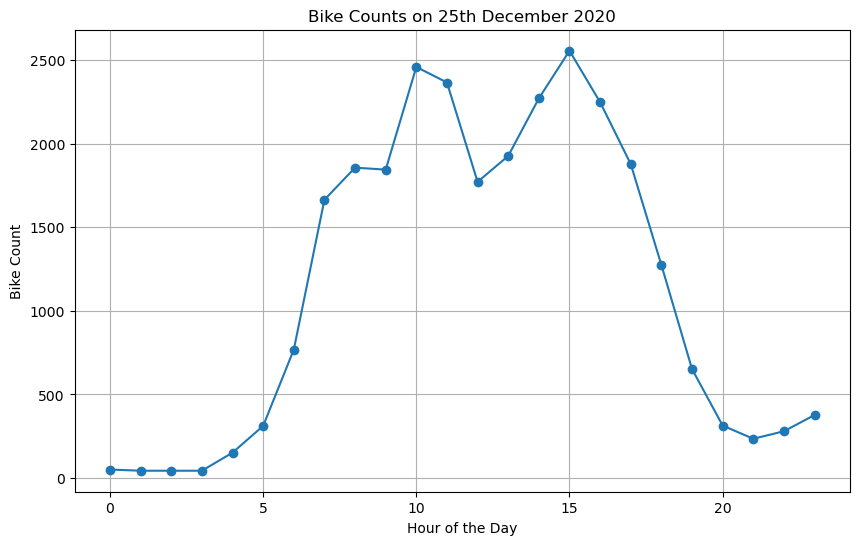

In [23]:
# Filter data for the specific date
specific_date_data = data[data["date"].dt.date == datetime.date(2020, 12, 24)]

# Group by hour and sum the bike counts
hourly_bike_counts = specific_date_data.groupby(specific_date_data["date"].dt.hour)["bike_count"].sum()

# Plot the bike counts for each hour of the specific date
plt.figure(figsize=(10, 6))
plt.plot(hourly_bike_counts.index, hourly_bike_counts.values, marker='o')
plt.title("Bike Counts on 25th December 2020")
plt.xlabel("Hour of the Day")
plt.ylabel("Bike Count")
plt.grid(True)
plt.show()

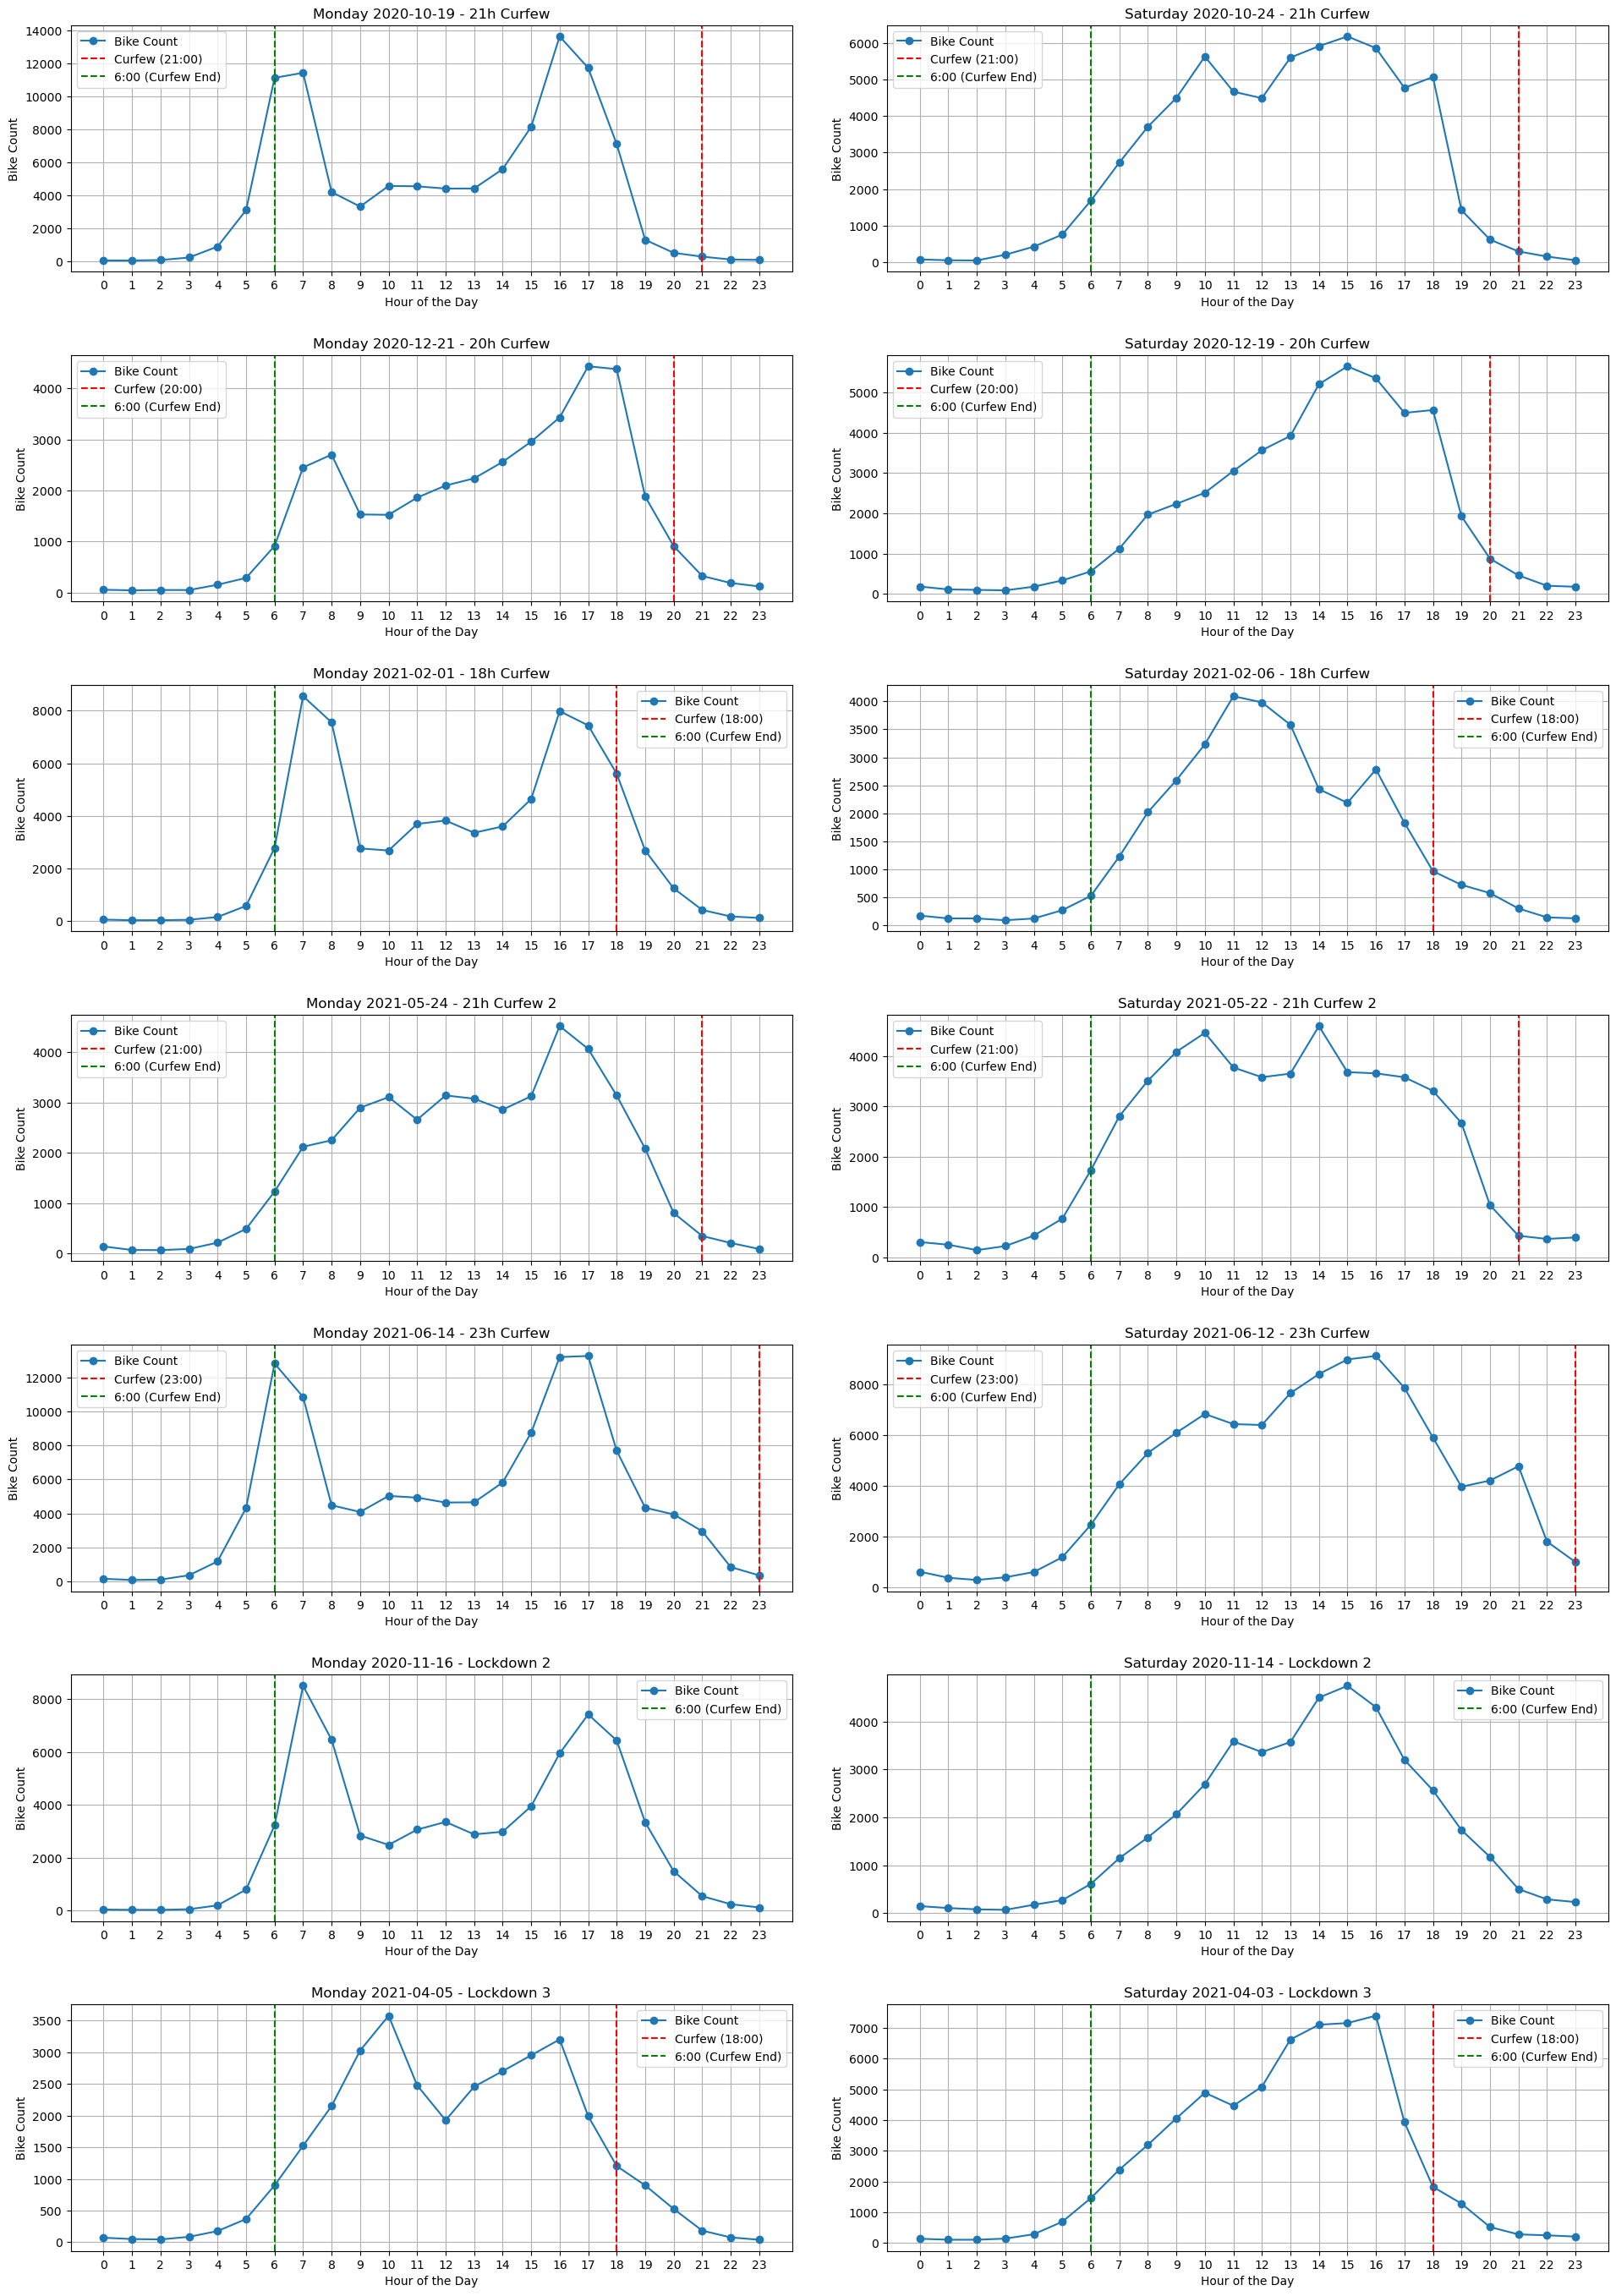

In [24]:
import datetime
import matplotlib.pyplot as plt

test_dates = [
    # Period pairs (Monday, Saturday)
    (datetime.date(2020, 10, 19), datetime.date(2020, 10, 24), "21h Curfew"),     # couvre_feu_21h
    (datetime.date(2020, 12, 21), datetime.date(2020, 12, 19), "20h Curfew"),     # couvre_feu_20h
    (datetime.date(2021, 2, 1), datetime.date(2021, 2, 6), "18h Curfew"),         # couvre_feu_18h
    (datetime.date(2021, 5, 24), datetime.date(2021, 5, 22), "21h Curfew 2"),     # couvre_feu_21h_2
    (datetime.date(2021, 6, 14), datetime.date(2021, 6, 12), "23h Curfew"),       # couvre_feu_23h
    (datetime.date(2020, 11, 16), datetime.date(2020, 11, 14), "Lockdown 2"),     # confinement_2
    (datetime.date(2021, 4, 5), datetime.date(2021, 4, 3), "Lockdown 3")          # confinement_3
]
fig, axs = plt.subplots(7, 2, figsize=(20, 28))
fig.tight_layout(pad=5.0)

for row, (monday_date, saturday_date, period) in enumerate(test_dates):
    # Process Monday data
    monday_data = data[data["date"].dt.date == monday_date]
    if len(monday_data) > 0:
        hourly_counts = monday_data.groupby(monday_data["date"].dt.hour)["bike_count"].sum()
        axs[row, 0].plot(hourly_counts.index, hourly_counts.values, marker='o', label='Bike Count')
        
        # Add curfew lines
        curfew_hour = None
        if monday_data['couvre_feu_21h'].iloc[0] == 1: curfew_hour = 21
        elif monday_data['couvre_feu_20h'].iloc[0] == 1: curfew_hour = 20
        elif monday_data['couvre_feu_18h'].iloc[0] == 1: curfew_hour = 18
        elif monday_data['couvre_feu_21h_2'].iloc[0] == 1: curfew_hour = 21
        elif monday_data['couvre_feu_23h'].iloc[0] == 1: curfew_hour = 23
        
        if curfew_hour:
            axs[row, 0].axvline(x=curfew_hour, color='r', linestyle='--', label=f'Curfew ({curfew_hour}:00)')
        axs[row, 0].axvline(x=6, color='g', linestyle='--', label='6:00 (Curfew End)')
        
        axs[row, 0].set_title(f"Monday {monday_date} - {period}")
    
    # Process Saturday data
    saturday_data = data[data["date"].dt.date == saturday_date]
    if len(saturday_data) > 0:
        hourly_counts = saturday_data.groupby(saturday_data["date"].dt.hour)["bike_count"].sum()
        axs[row, 1].plot(hourly_counts.index, hourly_counts.values, marker='o', label='Bike Count')
        
        # Add curfew lines
        curfew_hour = None
        if saturday_data['couvre_feu_21h'].iloc[0] == 1: curfew_hour = 21
        elif saturday_data['couvre_feu_20h'].iloc[0] == 1: curfew_hour = 20
        elif saturday_data['couvre_feu_18h'].iloc[0] == 1: curfew_hour = 18
        elif saturday_data['couvre_feu_21h_2'].iloc[0] == 1: curfew_hour = 21
        elif saturday_data['couvre_feu_23h'].iloc[0] == 1: curfew_hour = 23
        
        if curfew_hour:
            axs[row, 1].axvline(x=curfew_hour, color='r', linestyle='--', label=f'Curfew ({curfew_hour}:00)')
        axs[row, 1].axvline(x=6, color='g', linestyle='--', label='6:00 (Curfew End)')
        
        axs[row, 1].set_title(f"Saturday {saturday_date} - {period}")
    
    # Format both plots
    for col in range(2):
        axs[row, col].set_xlabel("Hour of the Day")
        axs[row, col].set_ylabel("Bike Count")
        axs[row, col].grid(True)
        axs[row, col].legend()
        axs[row, col].set_xticks(range(0, 24))

plt.show()

So finally, after all those steps, my dataset is composed of those columns : 

In [25]:
# List the columns of the dataset 

data.columns

Index(['counter_id', 'counter_name', 'site_id', 'site_name', 'bike_count',
       'date', 'counter_installation_date', 'coordinates',
       'counter_technical_id', 'latitude', 'longitude', 'log_bike_count',
       'year', 'month', 'day', 'weekday', 'hour', 'hour_sin', 'hour_cos',
       'day_sin', 'day_cos', 'is_bank_holiday', 'is_school_holiday',
       'confinement_2', 'confinement_3', 'couvre_feu_21h', 'couvre_feu_20h',
       'couvre_feu_18h', 'couvre_feu_21h_2', 'couvre_feu_23h',
       'rayon_deplacement_km', 'heure_couvre_feu', 'is_during_curfew',
       'is_within_allowed_distance'],
      dtype='object')

In [116]:
data.dtypes

counter_id                          category
counter_name                        category
site_id                                int64
site_name                           category
bike_count                           float64
date                          datetime64[us]
counter_installation_date     datetime64[us]
coordinates                         category
counter_technical_id                category
latitude                             float64
longitude                            float64
log_bike_count                       float64
year                                   int32
month                                  int32
day                                    int32
weekday                                int32
hour                                   int32
hour_sin                             float64
hour_cos                             float64
day_sin                              float64
day_cos                              float64
is_bank_holiday                        int64
is_school_

In [117]:
data.describe()

,site_id,bike_count,date,counter_installation_date,latitude,longitude,log_bike_count,year,month,day,weekday,hour,hour_sin,hour_cos,day_sin,day_cos,is_bank_holiday,is_school_holiday,confinement_2,confinement_3,couvre_feu_21h,couvre_feu_20h,couvre_feu_18h,couvre_feu_21h_2,couvre_feu_23h,rayon_deplacement_km,heure_couvre_feu,is_during_curfew,is_within_allowed_distance
count,4.968270e+05,496827.000000,496827,496827,496827.000000,496827.000000,496827.000000,496827.000000,496827.000000,496827.000000,496827.000000,496827.000000,4.968270e+05,4.968270e+05,496827.000000,496827.000000,496827.000000,496827.000000,496827.000000,496827.000000,496827.000000,496827.000000,496827.000000,496827.000000,496827.000000,496827.000000,496827.000000,496827.000000,496827.000000
mean,1.053450e+08,60.191475,2021-03-08 07:25:59.668858,2019-04-04 07:24:35.245911,48.854343,2.345479,3.079917,2020.679846,6.556904,15.458226,2.992172,11.502730,-2.474449e-05,-2.098861e-04,0.005761,-0.001693,0.029564,0.339180,0.120593,0.117989,0.031303,0.083973,0.328287,0.054216,0.029870,1.300481,10.071522,0.240188,0.238582
min,1.000070e+08,0.000000,2020-09-01 01:00:00,2013-01-18 00:00:00,48.826360,2.265420,0.000000,2020.000000,1.000000,1.000000,0.000000,0.000000,-1.000000e+00,-1.000000e+00,-0.974928,-0.900969,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000475e+08,5.000000,2020-12-05 22:00:00,2018-11-29 00:00:00,48.840801,2.314440,1.791759,2020.000000,4.000000,8.000000,1.000000,6.000000,-7.071068e-01,-7.071068e-01,-0.781831,-0.900969,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000562e+08,29.000000,2021-03-08 11:00:00,2019-11-06 00:00:00,48.852090,2.353870,3.401197,2021.000000,7.000000,15.000000,3.000000,12.000000,1.224647e-16,-1.836970e-16,0.000000,-0.222521,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000
75%,1.000563e+08,79.000000,2021-06-09 14:00:00,2019-12-11 00:00:00,48.864610,2.375870,4.382027,2021.000000,9.000000,23.000000,5.000000,18.000000,7.071068e-01,7.071068e-01,0.781831,0.623490,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000
max,3.000147e+08,1302.000000,2021-09-09 23:00:00,2020-11-29 00:00:00,48.891720,2.409690,7.172425,2021.000000,12.000000,31.000000,6.000000,23.000000,1.000000e+00,1.000000e+00,0.974928,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,23.000000,1.000000,1.000000
std,3.210346e+07,87.590566,NaN,NaN,0.018554,0.038026,1.659899,0.466536,3.423834,8.851485,1.995015,6.920936,7.071784e-01,7.070365e-01,0.707475,0.706715,0.169380,0.473432,0.325654,0.322595,0.174135,0.277347,0.469590,0.226444,0.170228,3.198162,9.593415,0.427198,0.426217


# 2. Visualizing the data - EDA


Let's visualize the data, starting from the spatial distribution of counters on the map

### Map - Location Information

The question : Does the location play a role in the bike count.

In [118]:
import folium

m = folium.Map(location=data[["latitude", "longitude"]].mean(axis=0), zoom_start=13)

for _, row in (
    data[["counter_name", "latitude", "longitude"]]
    .drop_duplicates("counter_name")
    .iterrows()
):
    folium.Marker(
        row[["latitude", "longitude"]].values.tolist(), popup=row["counter_name"]
    ).add_to(m)

m

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/folium/utilities.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coords = (location[0], location[1])


In [26]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import json
def add_district_information(df):
    """
    Adds district information to the DataFrame with error handling
    """
    # Manual corrections for known locations
    district_mapping = {
        'Voie Georges Pompidou NE-SO': 4,
        'Voie Georges Pompidou SO-NE': 4,
        '152 boulevard du Montparnasse E-O': 14,
        '152 boulevard du Montparnasse O-E': 14,
        'Face au 40 quai D\'Issy NE-SO': 15,
        'Face au 40 quai D\'Issy SO-NE': 15,
        # Add other known mappings here
    }
    
    try:
        # Apply manual mapping first
        df = df.copy()
        df['arrondissement'] = df['counter_name'].map(district_mapping)
        
        # Only process unmapped locations through the API
        unmapped = df[df['arrondissement'].isna()]
        if len(unmapped) > 0:
            # Create GeoDataFrame for unmapped points
            geometry = [Point(xy) for xy in zip(unmapped['longitude'], unmapped['latitude'])]
            gdf_points = gpd.GeoDataFrame(unmapped[['counter_name']], geometry=geometry)
            
            # Get district data from API
            url = "https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/arrondissements/records?limit=20"
            response = pd.read_json(url)
            
            # Create districts GeoDataFrame
            districts_data = [{
                'c_ar': district['c_ar'],
                'geometry': Polygon(district['geom']['geometry']['coordinates'][0])
            } for district in response['results']]
            districts = gpd.GeoDataFrame(districts_data)
            
            # Spatial join
            result = gpd.sjoin(gdf_points, districts[['geometry', 'c_ar']], how="left", predicate='within')
            api_mapping = dict(zip(result['counter_name'], result['c_ar']))
            
            # Update remaining values
            df.loc[df['arrondissement'].isna(), 'arrondissement'] = df.loc[df['arrondissement'].isna(), 'counter_name'].map(api_mapping)
        
        # Fill any remaining NaN values with 0 and convert to int
        df['arrondissement'] = df['arrondissement'].fillna(0).astype(int)
        return df
        
    except Exception as e:
        print(f"Warning: Error in district assignment: {e}")
        df['arrondissement'] = 0
        return df

# Utilisation
data = add_district_information(data)

# Vérification
print(data[['counter_name', 'arrondissement']].drop_duplicates())

                                           counter_name  arrondissement
48321                          28 boulevard Diderot E-O              12
57884                          28 boulevard Diderot O-E              12
67490                    39 quai François Mauriac NO-SE              13
77189                    39 quai François Mauriac SE-NO              13
87161                 18 quai de l'Hôtel de Ville NO-SE               4
96968                 18 quai de l'Hôtel de Ville SE-NO               4
116705                      Voie Georges Pompidou NE-SO               4
126152                      Voie Georges Pompidou SO-NE               4
135512                      67 boulevard Voltaire SE-NO              11
264221                Face au 48 quai de la marne NE-SO              19
273932                Face au 48 quai de la marne SO-NE              19
293567                 Face 104 rue d'Aubervilliers N-S              19
303599                 Face 104 rue d'Aubervilliers S-N         

In [27]:
# Arrondissement devrait être une variable catégorielle

data['arrondissement'] = data['arrondissement'].astype('category')

/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_5316/3058269372.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_bike_count_per_arrondissement = data.groupby('arrondissement')['bike_count'].mean()


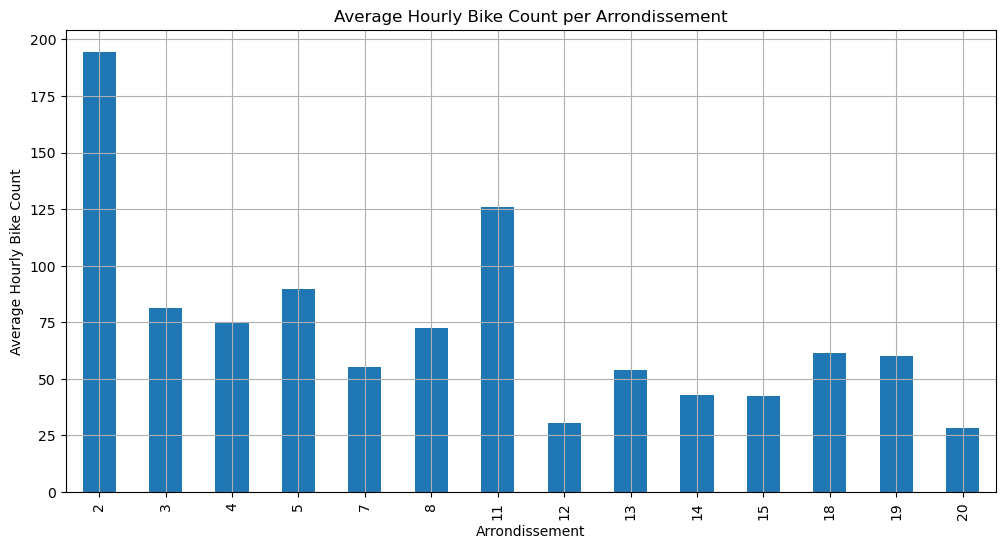

In [28]:
# Calculate the average hourly bike count per arrondissement
avg_bike_count_per_arrondissement = data.groupby('arrondissement')['bike_count'].mean()

# Plot the bar plot
plt.figure(figsize=(12, 6))
avg_bike_count_per_arrondissement.plot(kind='bar')
plt.title('Average Hourly Bike Count per Arrondissement')
plt.xlabel('Arrondissement')
plt.ylabel('Average Hourly Bike Count')
plt.grid(True)
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(12, 8))

# Create a kernel density plot
sns.kdeplot(
    data=data,
    x='longitude',
    y='latitude',
    weights='bike_count',  # Weight the density by bike count
    cmap='Blues',         # Use blue color palette
    fill=True,           # Fill the contours
    alpha=0.5,           # Set transparency
    levels=20,           # Number of contour levels
)

# Customize the plot
plt.title('Bike Count Density in Paris')
plt.grid(True, alpha=0.3)

# Add rugs (the small lines on the axes)
sns.rugplot(data=data, x='longitude', alpha=0.3, color='blue')
sns.rugplot(data=data, y='latitude', alpha=0.3, color='blue')

# Set axis labels
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

Note that in this challenge, we consider only the 30 most frequented counting sites, to limit data size.

Next we will look into the temporal distribution of the most frequented bike counter. If we plot it directly we will not see much because there are half a million data points:

## Date Information

Instead we aggregate the data, for instance, by week to have a clearer overall picture:

/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_5316/1998131824.py:1: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  data.groupby([pd.Grouper(freq="1w", key="date")])[["bike_count"]].sum().plot()


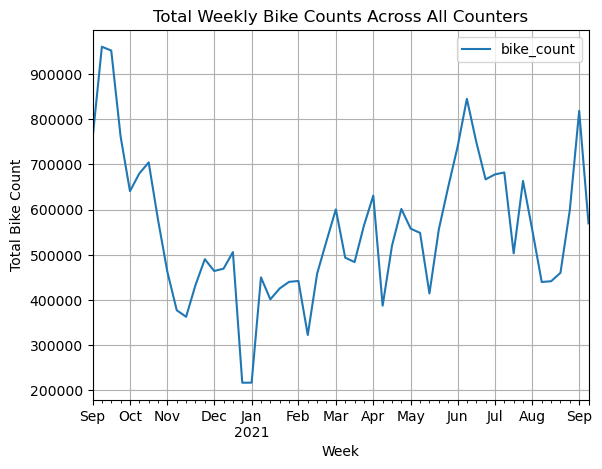

In [29]:
data.groupby([pd.Grouper(freq="1w", key="date")])[["bike_count"]].sum().plot()
plt.title("Total Weekly Bike Counts Across All Counters")
plt.ylabel("Total Bike Count")
plt.xlabel("Week")
plt.grid(True)
plt.show()

#### Graph with hollidays

/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_5316/2934995956.py:2: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  weekly_data = data.groupby([pd.Grouper(freq="1w", key="date")])[["bike_count", "is_school_holiday"]].agg({


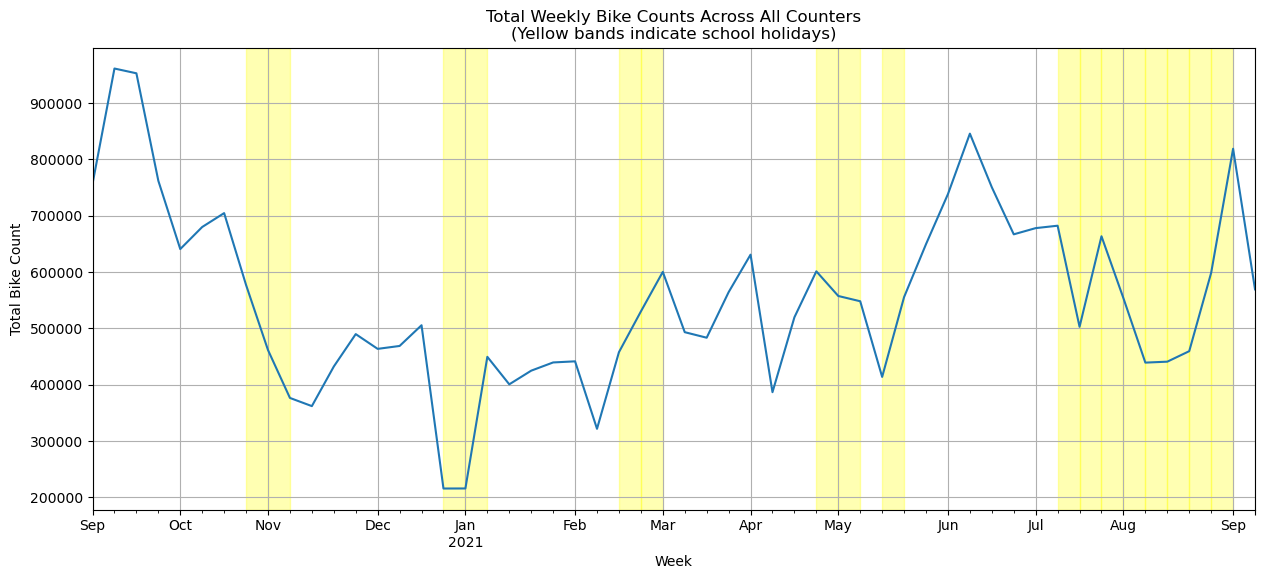

In [30]:
# Get weekly totals
weekly_data = data.groupby([pd.Grouper(freq="1w", key="date")])[["bike_count", "is_school_holiday"]].agg({
    "bike_count": "sum",
    "is_school_holiday": "mean"  # This gives us the proportion of the week that was holiday
})

# Plot
fig, ax = plt.subplots(figsize=(15, 6))
weekly_data["bike_count"].plot(ax=ax)

# Highlight holiday periods
holiday_periods = weekly_data[weekly_data["is_school_holiday"] > 0.5].index
for start_date in holiday_periods:
    ax.axvspan(start_date, start_date + pd.Timedelta(days=7), color='yellow', alpha=0.3)

plt.title("Total Weekly Bike Counts Across All Counters\n(Yellow bands indicate school holidays)")
plt.ylabel("Total Bike Count")
plt.xlabel("Week")
plt.grid(True)
plt.show()

#### Lowkdowns

/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_5316/3043457854.py:2: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  weekly_data = data.groupby([pd.Grouper(freq="1w", key="date")])[


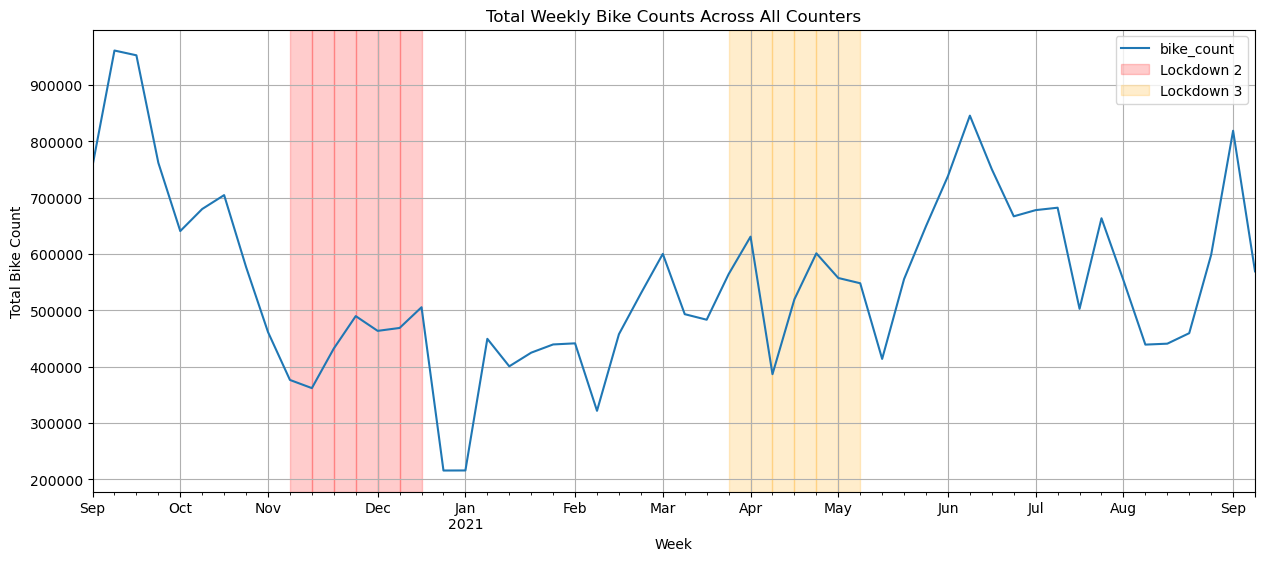

In [31]:
# Get weekly totals and restrictions
weekly_data = data.groupby([pd.Grouper(freq="1w", key="date")])[
    ["bike_count", "confinement_2", "confinement_3"]
].agg({
    "bike_count": "sum",
    "confinement_2": "mean",
    "confinement_3": "mean"
})

# Plot
fig, ax = plt.subplots(figsize=(15, 6))
weekly_data["bike_count"].plot(ax=ax)

# Highlight lockdown periods
lockdown2_periods = weekly_data[weekly_data["confinement_2"] > 0.5].index
for start_date in lockdown2_periods:
    ax.axvspan(start_date, start_date + pd.Timedelta(days=7), color='red', alpha=0.2,
               label='Lockdown 2' if start_date == lockdown2_periods[0] else "")

lockdown3_periods = weekly_data[weekly_data["confinement_3"] > 0.5].index
for start_date in lockdown3_periods:
    ax.axvspan(start_date, start_date + pd.Timedelta(days=7), color='orange', alpha=0.2,
               label='Lockdown 3' if start_date == lockdown3_periods[0] else "")

plt.title("Total Weekly Bike Counts Across All Counters")
plt.ylabel("Total Bike Count")
plt.xlabel("Week")
plt.grid(True)
plt.legend()
plt.show()

#### Couvre-feu

/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_5316/2679148782.py:2: FutureWarning: 'w' is deprecated and will be removed in a future version, please use 'W' instead.
  weekly_data = data.groupby([pd.Grouper(freq="1w", key="date")])[


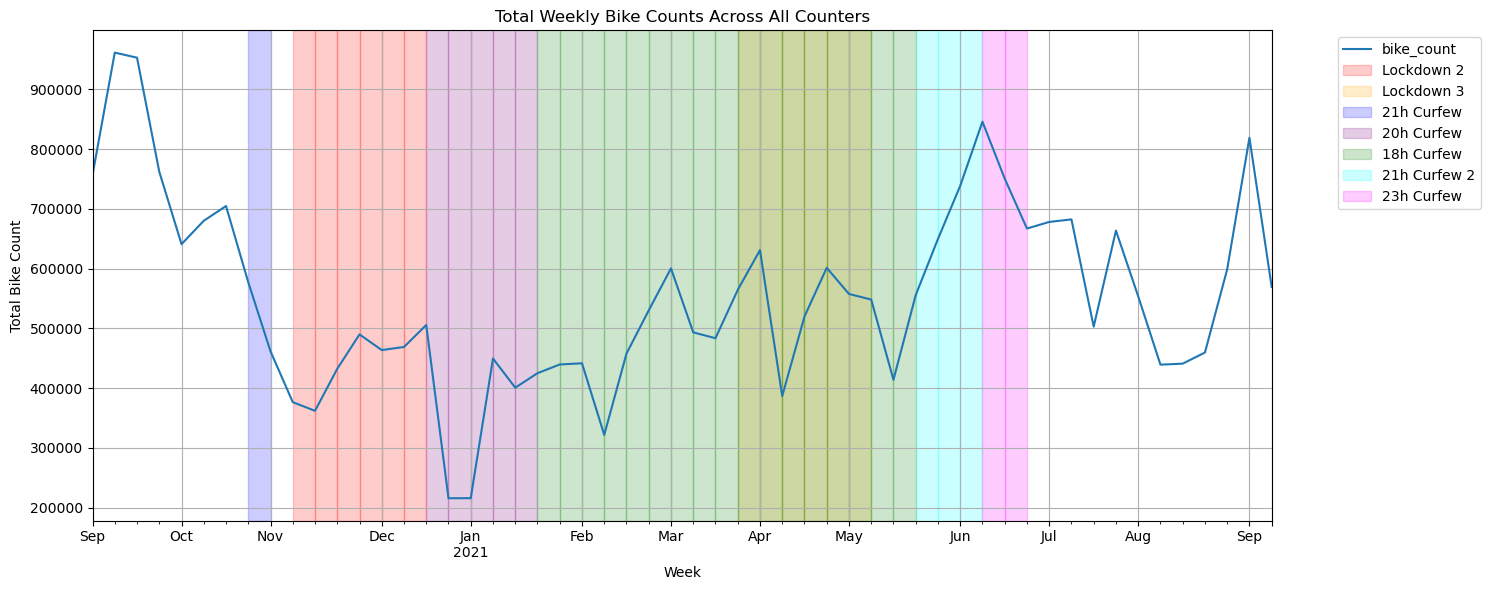

In [32]:
# Get weekly totals and restrictions
weekly_data = data.groupby([pd.Grouper(freq="1w", key="date")])[
    ["bike_count", "confinement_2", "confinement_3", 
     "couvre_feu_21h", "couvre_feu_20h", "couvre_feu_18h", 
     "couvre_feu_21h_2", "couvre_feu_23h"]
].agg({
    "bike_count": "sum",
    "confinement_2": "mean",
    "confinement_3": "mean",
    "couvre_feu_21h": "mean",
    "couvre_feu_20h": "mean",
    "couvre_feu_18h": "mean",
    "couvre_feu_21h_2": "mean",
    "couvre_feu_23h": "mean"
})

# Plot
fig, ax = plt.subplots(figsize=(15, 6))
weekly_data["bike_count"].plot(ax=ax)

# Define colors for different restrictions
colors = {
    'lockdown2': 'red',
    'lockdown3': 'orange',
    'curfew_21h': 'blue',
    'curfew_20h': 'purple',
    'curfew_18h': 'green',
    'curfew_21h_2': 'cyan',
    'curfew_23h': 'magenta'
}

# Highlight lockdown periods
for start_date in weekly_data[weekly_data["confinement_2"] > 0.5].index:
    ax.axvspan(start_date, start_date + pd.Timedelta(days=7), color=colors['lockdown2'], alpha=0.2,
               label='Lockdown 2' if start_date == weekly_data[weekly_data["confinement_2"] > 0.5].index[0] else "")

for start_date in weekly_data[weekly_data["confinement_3"] > 0.5].index:
    ax.axvspan(start_date, start_date + pd.Timedelta(days=7), color=colors['lockdown3'], alpha=0.2,
               label='Lockdown 3' if start_date == weekly_data[weekly_data["confinement_3"] > 0.5].index[0] else "")

# Highlight curfew periods
curfew_pairs = [
    ("couvre_feu_21h", "21h Curfew", 'curfew_21h'),
    ("couvre_feu_20h", "20h Curfew", 'curfew_20h'),
    ("couvre_feu_18h", "18h Curfew", 'curfew_18h'),
    ("couvre_feu_21h_2", "21h Curfew 2", 'curfew_21h_2'),
    ("couvre_feu_23h", "23h Curfew", 'curfew_23h')
]

for col, label, color_key in curfew_pairs:
    periods = weekly_data[weekly_data[col] > 0.5].index
    for start_date in periods:
        ax.axvspan(start_date, start_date + pd.Timedelta(days=7), 
                  color=colors[color_key], alpha=0.2,
                  label=label if start_date == periods[0] else "")

plt.title("Total Weekly Bike Counts Across All Counters")
plt.ylabel("Total Bike Count")
plt.xlabel("Week")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Graph for a particular day and counter

In [33]:
def plot_bike_hourly(data, date, counter_name):
    specific_date = pd.to_datetime(date).date()
    mask = (data["date"].dt.date == specific_date) & (data["counter_name"] == counter_name)
    specific_data = data[mask]
    
    if len(specific_data) == 0:
        print(f"No data available for {date}")
        return
    
    # Get restrictions status
    restrictions = []
    if specific_data['confinement_2'].iloc[0]: restrictions.append("Lockdown 2")
    if specific_data['confinement_3'].iloc[0]: restrictions.append("Lockdown 3")
    if specific_data['couvre_feu_21h'].iloc[0]: restrictions.append("21h Curfew")
    if specific_data['couvre_feu_20h'].iloc[0]: restrictions.append("20h Curfew")
    if specific_data['couvre_feu_18h'].iloc[0]: restrictions.append("18h Curfew")
    if specific_data['couvre_feu_21h_2'].iloc[0]: restrictions.append("21h Curfew 2")
    if specific_data['couvre_feu_23h'].iloc[0]: restrictions.append("23h Curfew")
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    hourly_counts = specific_data.groupby(specific_data["date"].dt.hour)["bike_count"].sum()
    ax.plot(hourly_counts.index, hourly_counts.values, marker='o', label='Bike Count')
    
    # Add curfew lines if applicable
    for restriction in restrictions:
        if 'Curfew' in restriction:
            curfew_hour = int(restriction.split('h')[0])
            ax.axvline(x=curfew_hour, color='r', linestyle='--', 
                      label=f'Curfew ({curfew_hour}:00)')
            ax.axvline(x=6, color='g', linestyle='--', 
                      label='6:00 (Curfew End)')
    
    # Formatting
    day_name = pd.to_datetime(date).strftime('%A')
    title = f"Bike Count on {date} ({day_name})\n"
    title += "Restrictions: " + ", ".join(restrictions) if restrictions else "No restrictions"
    
    ax.set_title(title)
    ax.set_xlabel("Hour of the Day")
    ax.set_ylabel("Bike Count")
    ax.grid(True)
    ax.legend()
    ax.set_xticks(range(0, 24))
    
    plt.show()

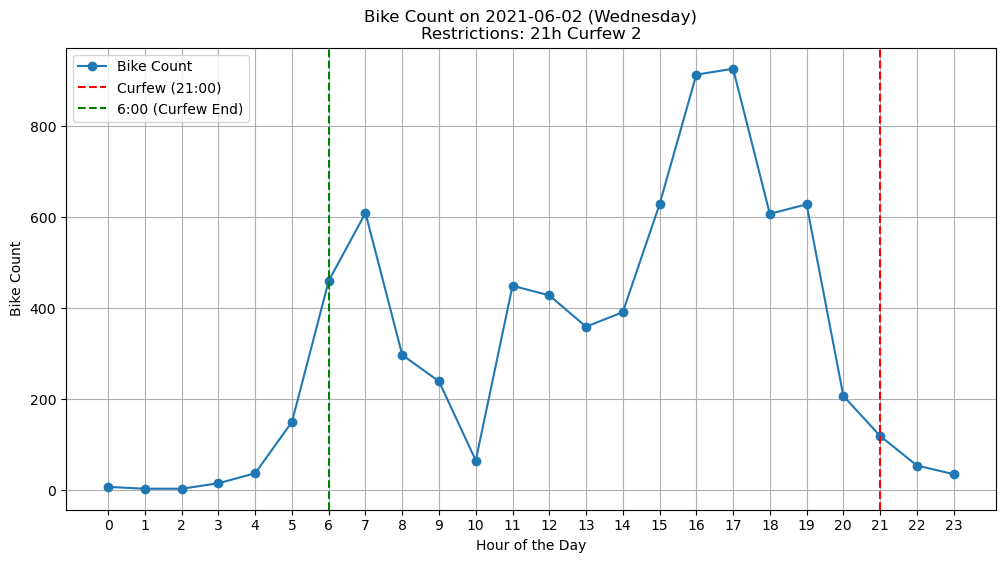

In [34]:
# Example usage:
plot_bike_hourly(data, "2021-06-02", "Totem 73 boulevard de Sébastopol S-N")

#### For all counters

In [35]:
def plot_total_bike_hourly(data, date):
    specific_date = pd.to_datetime(date).date()
    mask = data["date"].dt.date == specific_date
    specific_data = data[mask]
    
    if len(specific_data) == 0:
        print(f"No data available for {date}")
        return
    
    # Get restrictions status
    restrictions = []
    if specific_data['confinement_2'].iloc[0]: restrictions.append("Lockdown 2")
    if specific_data['confinement_3'].iloc[0]: restrictions.append("Lockdown 3")
    if specific_data['couvre_feu_21h'].iloc[0]: restrictions.append("21h Curfew")
    if specific_data['couvre_feu_20h'].iloc[0]: restrictions.append("20h Curfew")
    if specific_data['couvre_feu_18h'].iloc[0]: restrictions.append("18h Curfew")
    if specific_data['couvre_feu_21h_2'].iloc[0]: restrictions.append("21h Curfew 2")
    if specific_data['couvre_feu_23h'].iloc[0]: restrictions.append("23h Curfew")
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 6))
    hourly_counts = specific_data.groupby(specific_data["date"].dt.hour)["bike_count"].sum()
    ax.plot(hourly_counts.index, hourly_counts.values, marker='o', label='Total Bike Count')
    
    # Add curfew lines if applicable
    for restriction in restrictions:
        if 'Curfew' in restriction:
            curfew_hour = int(restriction.split('h')[0])
            ax.axvline(x=curfew_hour, color='r', linestyle='--', 
                      label=f'Curfew ({curfew_hour}:00)')
            ax.axvline(x=6, color='g', linestyle='--', 
                      label='6:00 (Curfew End)')
    
    # Formatting
    day_name = pd.to_datetime(date).strftime('%A')
    title = f"Total Bike Count on {date} ({day_name})\n"
    title += "Restrictions: " + ", ".join(restrictions) if restrictions else "No restrictions"
    
    ax.set_title(title)
    ax.set_xlabel("Hour of the Day")
    ax.set_ylabel("Total Bike Count")
    ax.grid(True)
    ax.legend()
    ax.set_xticks(range(0, 24))
    
    plt.show()

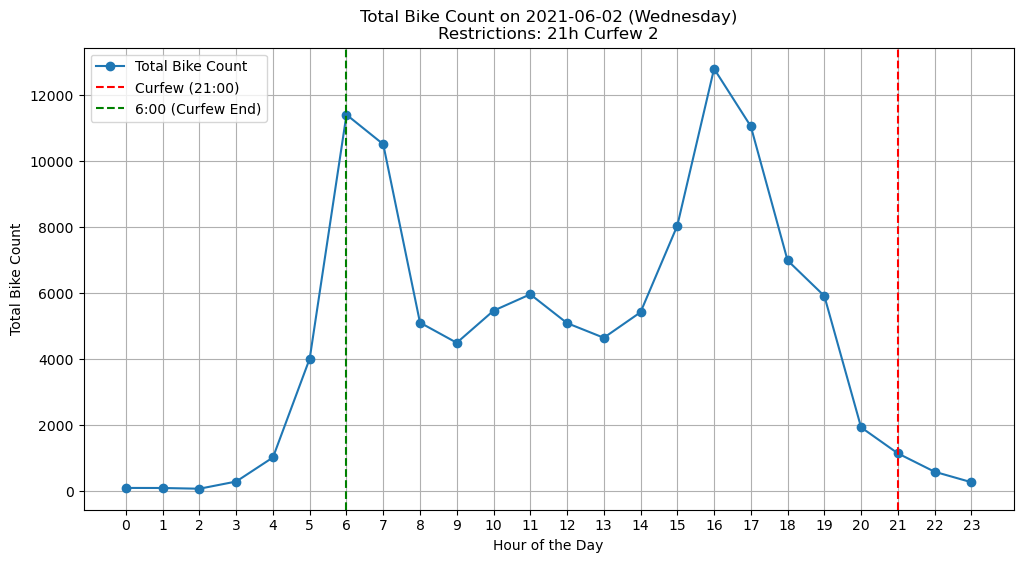

In [36]:
# Example usage:

plot_total_bike_hourly(data, "2021-06-02")

#### Information per week

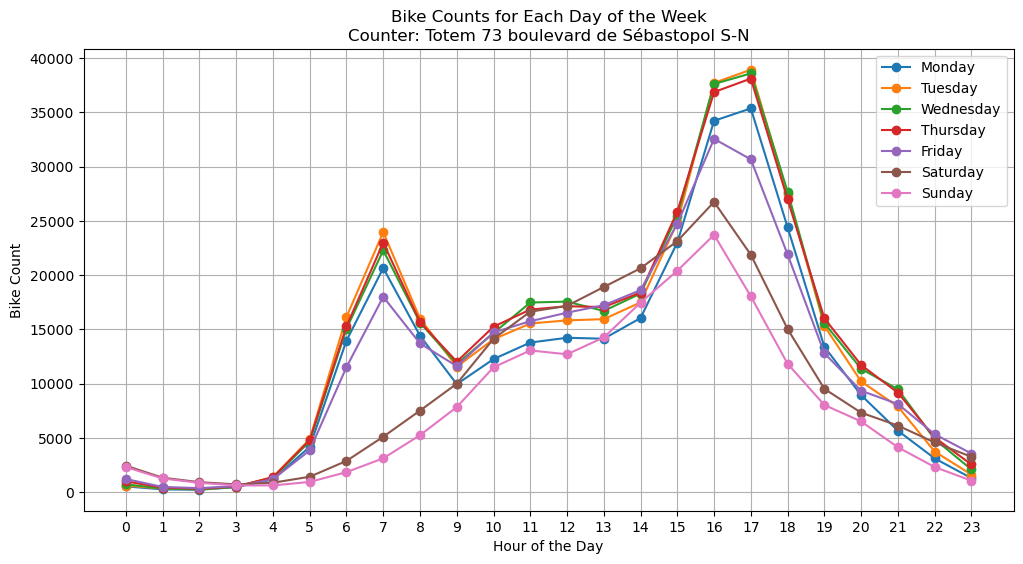

In [37]:
def plot_weekly_bike_counts(data, counter_name):
    # Filter data for the specific counter
    mask = data["counter_name"] == counter_name
    counter_data = data[mask]
    
    if len(counter_data) == 0:
        print(f"No data available for counter: {counter_name}")
        return
    
    # Create a pivot table to aggregate bike counts by hour and weekday
    pivot_table = counter_data.pivot_table(
        values="bike_count", 
        index=counter_data["date"].dt.hour, 
        columns=counter_data["date"].dt.weekday, 
        aggfunc="sum" # Total bike count for each hour of each weekday in the dateframe
    )
    
    # Plot the bike counts for each day of the week
    fig, ax = plt.subplots(figsize=(12, 6))
    days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    
    for i, day in enumerate(days):
        if i in pivot_table.columns:
            ax.plot(pivot_table.index, pivot_table[i], marker='o', label=day)
    
    # Formatting
    ax.set_title(f"Bike Counts for Each Day of the Week\nCounter: {counter_name}")
    ax.set_xlabel("Hour of the Day")
    ax.set_ylabel("Bike Count")
    ax.grid(True)
    ax.legend()
    ax.set_xticks(range(0, 24))
    
    plt.show()

# Example usage:
plot_weekly_bike_counts(data, "Totem 73 boulevard de Sébastopol S-N")

## Detecting Outliers

## Feature Repartition

The hourly pattern has a clear variation between work days and weekends (7 and 8 March 2021).

If we look at the distribution of the target variable it skewed and non normal, 

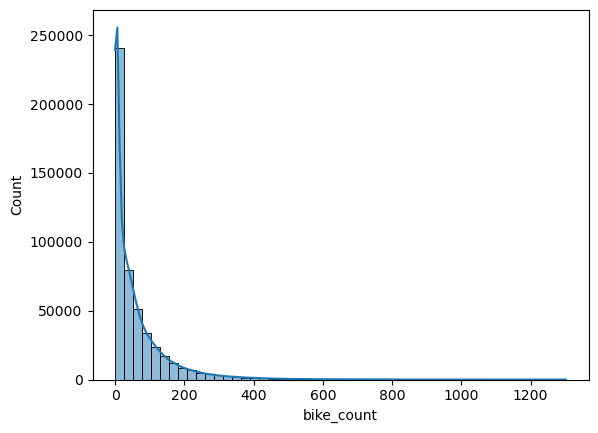

In [38]:
import seaborn as sns


ax = sns.histplot(data, x="bike_count", kde=True, bins=50)

Least square loss would not be appropriate to model it since it is designed for normal error distributions. One way to precede would be to transform the variable with a logarithmic transformation,
```py
data['log_bike_count'] = np.log(1 + data['bike_count'])
```

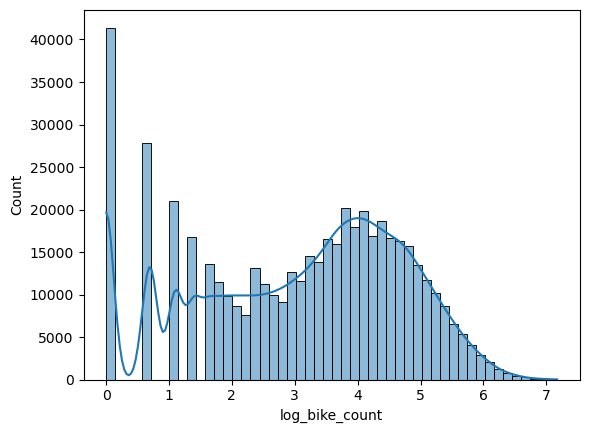

In [39]:
ax = sns.histplot(data, x="log_bike_count", kde=True, bins=50)

which has a more pronounced central mode, but is still non symmetric. In the following, **we use `log_bike_count` as the target variable** as otherwise `bike_count` ranges over 3 orders of magnitude and least square loss would be dominated by the few large values. 

# 3. Feature Engineering


Since it is unlikely that, for instance, that `hour` is linearly correlated with the target variable, we would need to additionally encode categorical features for linear models. This is classically done with [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), though other encoding strategies exist.

### Datatypes

In [40]:
# Convert data types
data = data.astype({
   'latitude': 'float64',
   'longitude': 'float64',
   'counter_id': 'category',
   'counter_name': 'category', 
   'site_id': 'category',
   'site_name': 'category',
   'counter_technical_id': 'category',
   'is_bank_holiday': 'int8',
   'is_school_holiday': 'int8',
   'year': 'int32',
   'month': 'int32', 
   'day': 'int32',
   'weekday': 'int32',
   'hour': 'int32',
   'date': 'datetime64[ns]',
   'counter_installation_date': 'datetime64[ns]'
})

# Verify new dtypes
print(data.dtypes)

counter_id                          category
counter_name                        category
site_id                             category
site_name                           category
bike_count                           float64
date                          datetime64[ns]
counter_installation_date     datetime64[ns]
coordinates                         category
counter_technical_id                category
latitude                             float64
longitude                            float64
log_bike_count                       float64
year                                   int32
month                                  int32
day                                    int32
weekday                                int32
hour                                   int32
hour_sin                             float64
hour_cos                             float64
day_sin                              float64
day_cos                              float64
is_bank_holiday                         int8
is_school_

# 4. Feature Selection

### DDD - Simple Feature Selection

In [41]:
def get_feature_lists(data, features):
    numerical_features = []
    categorical_features = []
    date_features = []
    
    for feature in features:
        if data[feature].dtype in [np.int64, np.float64]:
            numerical_features.append(feature)
        elif pd.api.types.is_datetime64_any_dtype(data[feature]):
            date_features.append(feature)
        else:
            categorical_features.append(feature)
            
    return numerical_features, categorical_features, date_features

List of all the features available : 

In [42]:
data.dtypes

counter_id                          category
counter_name                        category
site_id                             category
site_name                           category
bike_count                           float64
date                          datetime64[ns]
counter_installation_date     datetime64[ns]
coordinates                         category
counter_technical_id                category
latitude                             float64
longitude                            float64
log_bike_count                       float64
year                                   int32
month                                  int32
day                                    int32
weekday                                int32
hour                                   int32
hour_sin                             float64
hour_cos                             float64
day_sin                              float64
day_cos                              float64
is_bank_holiday                         int8
is_school_

In [87]:
# Select the features to use

LIST_FEATURES = ['date', 'counter_id', 'site_id', 'is_bank_holiday', 'is_school_holiday', 'month', 'weekday', 
                 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'latitude', 'longitude', 'arrondissement',]

numerical_features, categorical_features, date_features = get_feature_lists(data, LIST_FEATURES)

#### Defining X and Y for the model 

In [88]:
X = data[LIST_FEATURES]

y = data["log_bike_count"]

In [89]:
X.shape

(496827, 14)

In [90]:
y.shape

(496827,)

# 5. Building the Models - Pipelines

### Spliting the Training and Testing Set

Where `y` contains the `log_bike_count` variable. 

To test our baseline estimator, we create a validations set from the training set. Note that, during modeling and exploring the data, we always recommend using cross validation rather than a single train / validation split to evaluate your first results, because this will bring more stability and generalization.

We create the validation set by simply slicing the last 30 days of the training set, which is similar to the realty:

In [91]:
def train_test_split_temporal(X, y, delta_threshold="30 days"):
    
    cutoff_date = X["date"].max() - pd.Timedelta(delta_threshold)
    mask = (X["date"] <= cutoff_date)
    X_train, X_valid = X.loc[mask], X.loc[~mask]
    y_train, y_valid = y[mask], y[~mask]

    return X_train, y_train, X_valid, y_valid

In [92]:
X_train, y_train, X_valid, y_valid = train_test_split_temporal(X, y)

print(
    f'Train: n_samples={X_train.shape[0]},  {X_train["date"].min()} to {X_train["date"].max()}'
)
print(
    f'Valid: n_samples={X_valid.shape[0]},  {X_valid["date"].min()} to {X_valid["date"].max()}'
)

Train: n_samples=456507,  2020-09-01 01:00:00 to 2021-08-10 23:00:00
Valid: n_samples=40320,  2021-08-11 00:00:00 to 2021-09-09 23:00:00


### DDD -  Creating the pipeline - Choosing the Model

In [93]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestRegressor,
    ExtraTreesRegressor
)
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet
)
# Install lightgbm
%pip install lightgbm

import lightgbm as lgb
import pandas as pd
import numpy as np

# Install xgboost
%pip install xgboost
import xgboost as xgb

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Testing one model : 

In [94]:
# Create preprocessor
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), 
     categorical_features)
])

In [99]:
# Create the pipeline 
model_solo = GradientBoostingRegressor(n_estimators=80,max_depth=40)

solo_pipe = make_pipeline(preprocessor, model_solo)

# Fit the model

solo_pipe.fit(X_train, y_train)

# Predict on the validation set

y_pred = solo_pipe.predict(X_valid)

# Calculate the RMSE

rmse = mean_squared_error(y_valid, y_pred, squared=False)

print(f"Validation RMSE: {rmse:.2f}")



Validation RMSE: 0.48


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [86]:
# Perform cross-validation
cv = TimeSeriesSplit(n_splits=5)
cv_scores = cross_val_score(solo_pipe, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')

# Calculate the mean and standard deviation of the RMSE
cv_rmse = (-cv_scores) ** 0.5
print(f"Cross-Validation RMSE: {cv_rmse.mean():.2f} ± {cv_rmse.std():.2f}")

KeyboardInterrupt: 

### Testing several one : 

In [80]:
# Define models with default parameters
models = {
    "Ridge": Ridge(),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=20),
    "RandomForest": RandomForestRegressor(n_estimators=50),
    "ExtraTrees": ExtraTreesRegressor(n_estimators=50),
    "XGBoost": xgb.XGBRegressor(n_estimators=50),
    "LightGBM": lgb.LGBMRegressor(n_estimators=50)
}

results = {}

In [75]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score

#### Cross-Validation

In [76]:
# Evaluate each model
for name, model in models.items():
    try:
        # Create and fit pipeline
        pipe = make_pipeline(preprocessor, model)
        pipe.fit(X_train, y_train)
        
        # Calculate RMSE
        train_rmse = mean_squared_error(y_train, pipe.predict(X_train), squared=False)
        valid_rmse = mean_squared_error(y_valid, pipe.predict(X_valid), squared=False)
        
        # Cross validation
        cv = TimeSeriesSplit(n_splits=6)
        cv_scores = cross_val_score(pipe, X_train, y_train, 
                                  cv=cv, scoring="neg_root_mean_squared_error")
        
        results[name] = {
            'train_rmse': train_rmse,
            'valid_rmse': valid_rmse,
            'cv_mean': -cv_scores.mean(),
            'cv_std': cv_scores.std()
        }
        
        print(f"\n{name} Results:")
        print(f"Train RMSE: {train_rmse:.4f}")
        print(f"Valid RMSE: {valid_rmse:.4f}")
        print(f"CV Score: {-cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
        
    except Exception as e:
        print(f"\nError evaluating {name}: {e}")
        continue

# Create results summary DataFrame
results_df = pd.DataFrame({
    'Train RMSE': {k: v['train_rmse'] for k, v in results.items()},
    'Valid RMSE': {k: v['valid_rmse'] for k, v in results.items()},
    'CV Mean RMSE': {k: v['cv_mean'] for k, v in results.items()},
    'CV Std RMSE': {k: v['cv_std'] for k, v in results.items()}
}).sort_values('Valid RMSE')

print("\nModel Performance Summary:")
print(results_df)

# Get best model
best_model_name = results_df.index[0]
best_pipe = make_pipeline(preprocessor, models[best_model_name])
best_pipe.fit(X_train, y_train)

print(f"\nBest Model: {best_model_name}")
print(f"Validation RMSE: {results_df.loc[best_model_name, 'Valid RMSE']:.4f}")

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



Ridge Results:
Train RMSE: 0.7932
Valid RMSE: 0.7306
CV Score: 1.0467 ± 0.1944


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



GradientBoosting Results:
Train RMSE: 0.9843
Valid RMSE: 0.9320
CV Score: 1.0833 ± 0.1653


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



RandomForest Results:
Train RMSE: 0.1460
Valid RMSE: 0.4336
CV Score: 0.9792 ± 0.1731


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



ExtraTrees Results:
Train RMSE: 0.0000
Valid RMSE: 0.4554
CV Score: 0.9419 ± 0.2087


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



XGBoost Results:
Train RMSE: 0.5259
Valid RMSE: 0.5652
CV Score: 0.9404 ± 0.2007
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012011 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 480
[LightGBM] [Info] Number of data points in the train set: 456507, number of used features: 188
[LightGBM] [Info] Start training from score 3.048868


/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 263
[LightGBM] [Info] Number of data points in the train set: 65217, number of used features: 105
[LightGBM] [Info] Start training from score 2.696707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 298
[LightGBM] [Info] Number of data points in the train set: 130432, number of used features: 118
[LightGBM] [Info] Start training from score 2.946948
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enou

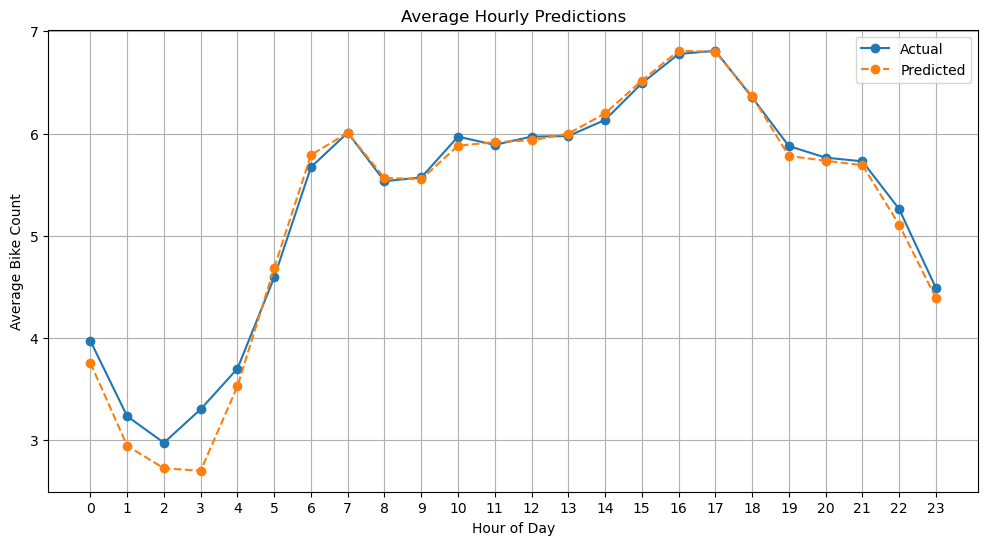

In [77]:
# Plot predictions for one station with hourly aggregation
mask = (
    (data.loc[X_valid.index, "counter_name"] == "Totem 73 boulevard de Sébastopol S-N")
    & (data.loc[X_valid.index, "date"] > pd.to_datetime("2021/09/01"))
    & (data.loc[X_valid.index, "date"] < pd.to_datetime("2021/09/08"))
)

df_viz = X_valid.loc[mask].copy()
df_viz["bike_count"] = y_valid[mask]
df_viz["bike_count_predicted"] = best_pipe.predict(X_valid[mask])
df_viz["hour"] = data.loc[df_viz.index, "date"].dt.hour
df_viz["date"] = data.loc[df_viz.index, "date"].dt.date

# Aggregate by hour
hourly_actual = df_viz.groupby("hour")["bike_count"].mean()
hourly_predicted = df_viz.groupby("hour")["bike_count_predicted"].mean()

plt.figure(figsize=(12, 6))
plt.plot(hourly_actual.index, hourly_actual.values, label="Actual", marker='o')
plt.plot(hourly_predicted.index, hourly_predicted.values, '--', label="Predicted", marker='o')
plt.title("Average Hourly Predictions")
plt.xlabel("Hour of Day")
plt.ylabel("Average Bike Count")
plt.legend()
plt.grid(True)
plt.xticks(range(0, 24))
plt.show()

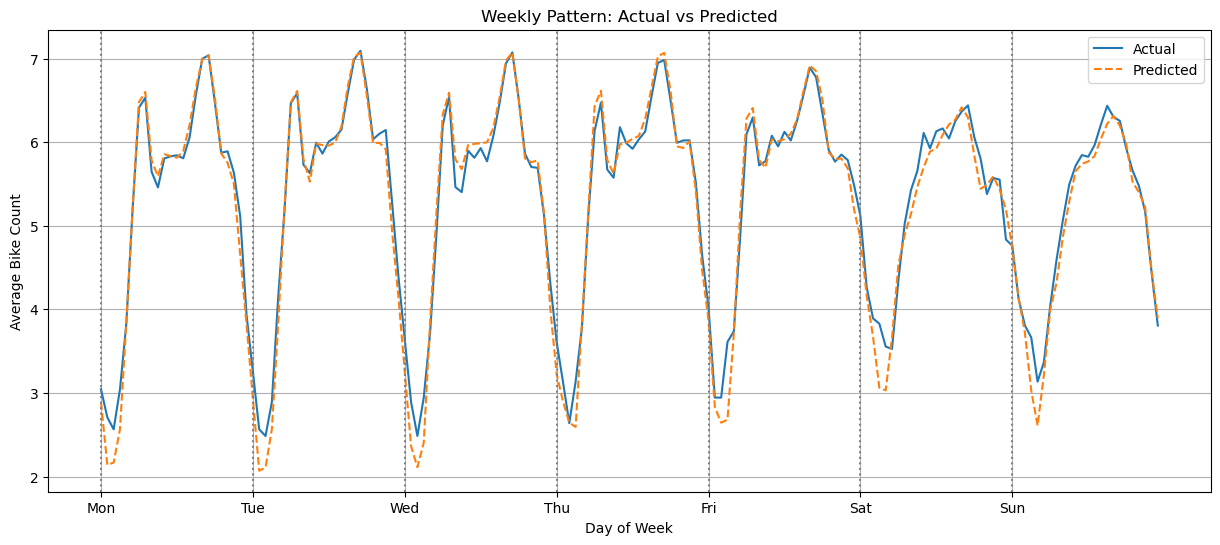

In [78]:
# Group by weekday and hour, get means
weekly_data = df_viz.groupby(['weekday', 'hour']).agg({
   'bike_count': 'mean',
   'bike_count_predicted': 'mean'
}).reset_index()

# Create x-axis with 24 hours per weekday (168 total points)
weekly_data['x_axis'] = weekly_data['weekday'] * 24 + weekly_data['hour']

plt.figure(figsize=(15, 6))
plt.plot(weekly_data['x_axis'], weekly_data['bike_count'], label='Actual')
plt.plot(weekly_data['x_axis'], weekly_data['bike_count_predicted'], '--', label='Predicted')

# Customize x-axis
plt.xticks(np.arange(0, 168, 24), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
for i in range(0, 168, 24):
   plt.axvline(x=i, color='gray', linestyle=':')

plt.title("Weekly Pattern: Actual vs Predicted")
plt.xlabel("Day of Week")
plt.ylabel("Average Bike Count")
plt.legend()
plt.grid(True)
plt.show()

So we start to see the daily trend, and some of the week day differences are accounted for, however we still miss the details and the spikes in the evening are under-estimated.

A useful way to visualize the error is to plot `y_pred` as a function of `y_true`,

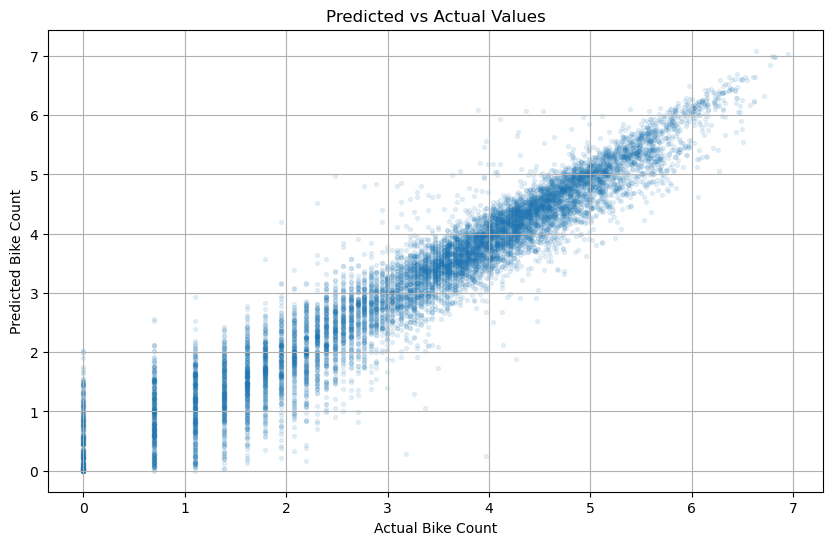

In [79]:
# Plot predicted vs actual values
fig, ax = plt.subplots(figsize=(10, 6))

df_viz = pd.DataFrame({
    "y_true": y_valid, 
    "y_pred": best_pipe.predict(X_valid)
}).sample(10000, random_state=0)

df_viz.plot.scatter(x="y_true", y="y_pred", s=8, alpha=0.1, ax=ax)
plt.title("Predicted vs Actual Values")
plt.xlabel("Actual Bike Count")
plt.ylabel("Predicted Bike Count")
plt.grid(True)
plt.show()

### Feature Importance for Linear Regression

It is recommended to use cross-validation for hyper-parameter tuning with [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) or more reliable model evaluation with [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn.model_selection.cross_val_score). In this case, because we want the test data to always be in the future as compared to the train data, we can use [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html):

<img src="https://i.stack.imgur.com/Q37Bn.png" />

The disadvantage, is that we can either have the training set size be different for each fold which is not ideal for hyper-parameter tuning (current figure), or have constant sized small training set which is also not ideal given the data periodicity. This explains that generally we will have worse cross-validation scores than test scores:

In [81]:
import shap

# Get preprocessed data
X_train_processed = best_pipe.named_steps['columntransformer'].transform(X_train)
X_valid_processed = best_pipe.named_steps['columntransformer'].transform(X_valid)

# Create feature names
feature_names = (numerical_features + 
                best_pipe.named_steps['columntransformer']
                .named_transformers_['cat'].get_feature_names_out(categorical_features).tolist())

# Create explainer with background data
background = X_train_processed[:100]
explainer = shap.KernelExplainer(best_pipe.named_steps[best_model.lower()].predict, background)

# Calculate SHAP values
shap_values = explainer.shap_values(X_valid_processed[:100])

# Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_valid_processed[:100], feature_names=feature_names)

/opt/anaconda3/envs/kaggle_velo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyError: 'gradientboostingregressor'

In [96]:
from sklearn.inspection import permutation_importance

# Assuming your model is called 'pipe'
result = permutation_importance(
    solo_pipe, X_valid, y_valid,
    n_repeats=10,
    random_state=42
)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': result.importances_mean
}).sort_values('importance', ascending=False)

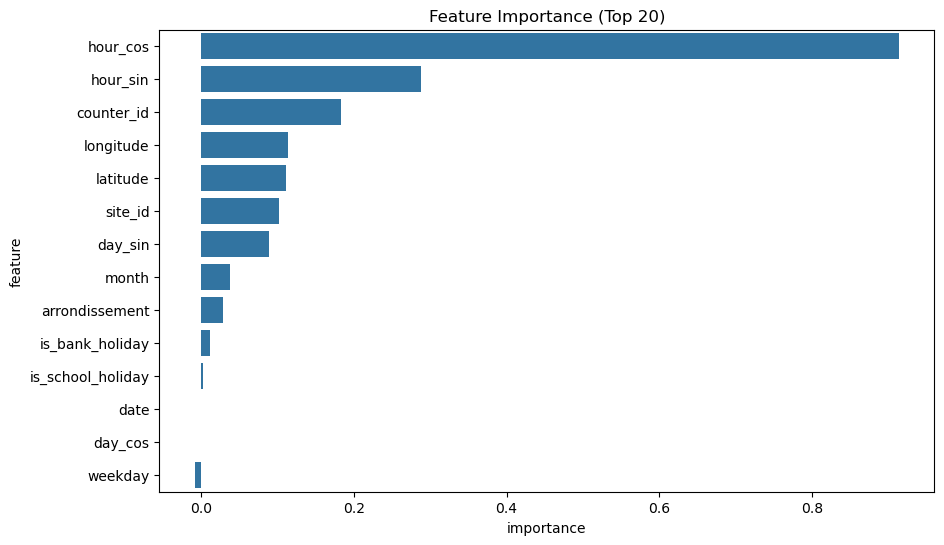

In [97]:
# Plotting the feature importance

fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=feature_importance.head(20), x='importance', y='feature', ax=ax)
ax.set_title('Feature Importance (Top 20)')
plt.show()


# 6. Hyperparameter Finetuning

### Using Random Grid Search 

In [ ]:
# Write a code to find the best hyperparameters for the model using GridSearchCV on GradientBoostingRegressor

from sklearn.model_selection import GridSearchCV

# Define the parameter grid

param_grid = {
    'gradientboostingregressor__n_estimators': [50, 100, 200],
    'gradientboostingregressor__max_depth': [5, 10, 20]
}

# Perform GridSearchCV
grid_search = GridSearchCV(
    solo_pipe, param_grid, cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error'
)

grid_search.fit(X_train, y_train)

# Get the best parameters

best_params = grid_search.best_params_

print(f"Best Parameters: {best_params}")

# Get the best model

best_model_solo = grid_search.best_estimator_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


### Using Flaml

In [69]:
def evaluate_with_flaml(X_train, y_train, X_valid, y_valid, time_budget_seconds=60):
    """
    Evaluate models using FLAML AutoML with proper TimeSeriesSplit initialization
    """
    # Create preprocessor
    preprocessor = ColumnTransformer([
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), 
         categorical_features)
    ])
    
    # Preprocess data
    X_train_processed = preprocessor.fit_transform(X_train)
    X_valid_processed = preprocessor.transform(X_valid)
    
    # Initialize AutoML
    automl = AutoML()
    
    # Create TimeSeriesSplit instance
    ts_split = TimeSeriesSplit(n_splits=5)
    
    # Configure settings for time series
    settings = {
        "time_budget": time_budget_seconds,
        "metric": 'rmse',
        "task": 'regression',
        "estimator_list": ['lgbm', 'xgboost', 'rf', 'extra_tree'],  # Changed 'extra_tree' to 'extra_trees'
        "eval_method": "cv",
        "n_splits": 5,
        "split_type": ts_split,  # Pass the instance instead of the class
        "seed": 42,
        "verbose": 2
    }
    
    try:
        # Train AutoML
        automl.fit(
            X_train_processed, 
            y_train,
            **settings
        )
        
        # Get results
        best_model = automl.model.estimator
        best_config = automl.best_config
        
        # Calculate metrics
        train_pred = automl.predict(X_train_processed)
        valid_pred = automl.predict(X_valid_processed)
        
        train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
        valid_rmse = np.sqrt(mean_squared_error(y_valid, valid_pred))
        
        return {
            'best_model': best_model,
            'best_config': best_config,
            'train_rmse': train_rmse,
            'valid_rmse': valid_rmse,
            'automl': automl,
            'preprocessor': preprocessor
        }
    
    except Exception as e:
        print(f"An error occurred during FLAML evaluation: {str(e)}")
        return None

def compare_manual_and_flaml(X_train, y_train, X_valid, y_valid, manual_results, flaml_results):
    """
    Compare results from manual model selection and FLAML
    """
    if flaml_results is None:
        print("FLAML evaluation failed. Cannot compare results.")
        return None
        
    # Create comparison DataFrame
    comparison = pd.DataFrame({
        'Model': ['Best Manual', 'FLAML'],
        'Train RMSE': [
            min(r['train_rmse'] for r in manual_results.values()),
            flaml_results['train_rmse']
        ],
        'Valid RMSE': [
            min(r['valid_rmse'] for r in manual_results.values()),
            flaml_results['valid_rmse']
        ]
    })
    
    return comparison.set_index('Model')

In [70]:
# Install flaml
%pip install flaml

from flaml import AutoML

Note: you may need to restart the kernel to use updated packages.


In [71]:
# Run FLAML evaluation
flaml_results = evaluate_with_flaml(
    X_train, y_train, 
    X_valid, y_valid,
    time_budget_seconds=300  # 5 minutes
)

# Compare results
if flaml_results is not None:
    comparison = compare_manual_and_flaml(
        X_train, y_train, 
        X_valid, y_valid,
        results,  
        flaml_results
    )
    print("\nComparison of approaches:")
    print(comparison)

    if flaml_results['valid_rmse'] < min(r['valid_rmse'] for r in results.values()):
        print("\nFLAML found better model!")
        print("\nBest configuration found by FLAML:")
        print(flaml_results['best_config'])

An error occurred during FLAML evaluation: '[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 

# 7. Training model on the whole Training Set

In [54]:
def describe_pipeline(pipe):
    """
    Describe the components of a pipeline.

    Parameters
    ----------
    pipe : sklearn.pipeline.Pipeline
        The pipeline to describe.

    Returns
    -------
    None
    """
    for i, (name, step) in enumerate(pipe.steps):
        print(f"Step {i+1}: {name}")
        print(f"Component: {step}")
        print("-" * 30)

# Example usage:
# describe_pipeline(best_pipe)

In [55]:
describe_pipeline(best_pipe)

NameError: name 'best_pipe' is not defined

In [60]:
# I want to train the best model on the entire dataset X_train, y_train and X_valid, y_valid (New test)

# Create and fit pipeline

best_pipe.fit(X,y)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['hour_sin', 'hour_cos',
                                                   'day_sin', 'day_cos',
                                                   'latitude', 'longitude']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['counter_id', 'site_id',
                                                   'is_bank_holiday',
                                                   'is_school_holiday', 'year',
                                                   'month', 'day', 'weekday',
                                                   'hour',
                                                   'arrondissement'])])),
                ('gradientboostingregressor',
                 GradientBoostingRegressor(max_depth=10, n_estimators=10))])

# 8. Kaggle Preparation of the model

## Testing Set with my model

In [85]:
X_test = pd.read_parquet('../bike_counters/data/final_test.parquet')

In [84]:
import numpy as np
import pandas as pd
from jours_feries_france import JoursFeries
from vacances_scolaires_france import SchoolHolidayDates
from pathlib import Path

def prepare_test_data(X_test, pipe):
    """
    Prepare test data with all necessary features
    """
    # Basic date features
    X_test['year'] = X_test['date'].dt.year
    X_test['month'] = X_test['date'].dt.month
    X_test['day'] = X_test['date'].dt.day
    X_test['weekday'] = X_test['date'].dt.weekday
    X_test['hour'] = X_test['date'].dt.hour
    
    # Cyclic features
    X_test['hour_sin'] = np.sin(2 * np.pi * X_test['hour'] / 24)
    X_test['hour_cos'] = np.cos(2 * np.pi * X_test['hour'] / 24)
    X_test['day_sin'] = np.sin(2 * np.pi * X_test['weekday'] / 7)
    X_test['day_cos'] = np.cos(2 * np.pi * X_test['weekday'] / 7)
    
    # Holiday features - with error handling
    try:
        X_test['is_school_holiday'] = get_school_holidays(X_test['date'])
        X_test['is_bank_holiday'] = is_bank_holiday(X_test['date'])
    except Exception as e:
        print(f"Warning: Error processing holidays: {e}")
        X_test['is_school_holiday'] = 0
        X_test['is_bank_holiday'] = 0
    
    # District information
        X_test = add_district_information(X_test)
        
    # Ensure categorical columns are properly typed
    categorical_columns = ['counter_id', 'counter_name', 'site_id', 'site_name', 'counter_technical_id']
    for col in categorical_columns:
        if col in X_test.columns:
            X_test[col] = X_test[col].astype('category')
    
    return X_test

def generate_submission(X_test, pipe, output_file="submission.csv"):
    """
    Generate submission file with proper error handling
    """
    try:
        # Prepare test data
        X_test_prepared = prepare_test_data(X_test, pipe)
        
        # Make predictions
        y_pred = pipe.predict(X_test_prepared)
        
        # Create submission DataFrame
        results = pd.DataFrame({
            'Id': np.arange(len(y_pred)),
            'log_bike_count': y_pred
        })
        
        # Save results
        results.to_csv(output_file, index=False)
        print(f"Successfully generated submission file: {output_file}")
        
    except Exception as e:
        print(f"Error generating submission: {e}")
        raise

In [100]:
# Load and prepare test data
X_test = pd.read_parquet('../bike_counters/data/final_test.parquet')
X_test_prepared = prepare_test_data(X_test, solo_pipe)

# Generate submission
generate_submission(X_test_prepared, solo_pipe)

Loading school holidays from cache...


/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_5316/3945340143.py:48: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  holiday_series = holiday_series.fillna(False)


Loading school holidays from cache...


/var/folders/p5/5w2t1wsn3tx5219f3z3ndjfc0000gn/T/ipykernel_5316/3945340143.py:48: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  holiday_series = holiday_series.fillna(False)


Successfully generated submission file: submission.csv
